# QAOA 
Reference: https://pennylane.ai/qml/demos/tutorial_qaoa_maxcut

In [7]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
import os
from datetime import datetime
from pennylane import qaoa

## Graph generating function

In [8]:
def generate_random_graph(n_nodes=8, p=0.5, seed=None):
    G = nx.erdos_renyi_graph(n_nodes, p, seed=seed)
    for (u, v) in G.edges():
        G.edges[u, v]['weight'] = np.random.randint(1, 10)
    return G

## Algorithm function

In [9]:
def maxcut_qaoa(G, p_layers=1, optimizer_steps=50, seed=None):
    np.random.seed(seed)
    n = G.number_of_nodes()
    edges = list(G.edges())
    dev = qml.device("default.qubit", wires=n)

    # Build cost Hamiltonian using PennyLane's built-in function
    cost_h, _ = qaoa.maxcut(G)

    def qaoa_layer(gamma, beta):
        # Cost layer
        for (i, j) in edges:
            qml.CNOT(wires=[i, j])
            qml.RZ(-gamma, wires=j)
            qml.CNOT(wires=[i, j])
        # Mixer layer
        for i in range(n):
            qml.RX(2 * beta, wires=i)

    @qml.qnode(dev)
    def circuit(params):
        # Initial state
        for i in range(n):
            qml.Hadamard(wires=i)
        # QAOA layers
        for l in range(p_layers):
            qaoa_layer(params[l, 0], params[l, 1])
        return qml.expval(cost_h)

    # Initial parameters
    params = 0.01 * np.random.randn(p_layers, 2)
    opt = qml.GradientDescentOptimizer(stepsize=0.1)

    for step in range(optimizer_steps):
        params = opt.step(lambda v: -circuit(v), params)

    cut_value = circuit(params)
    return cut_value

## Experiment function

In [10]:
def run_qaoa_experiment_time_budget(sizes, edge_prob=0.5, time_per_size=420, p_layers=1, optimizer_steps=50):
    all_cut_values = []
    for n_nodes in sizes:
        cut_values = []
        start_time = time.time()
        g_idx = 0
        while time.time() - start_time < time_per_size:
            G = generate_random_graph(n_nodes=n_nodes, p=edge_prob, seed=g_idx)
            value = maxcut_qaoa(G, p_layers=p_layers, optimizer_steps=optimizer_steps, seed=g_idx)
            cut_values.append(value)
            g_idx += 1
        all_cut_values.append(cut_values)
        print(f"Size: {n_nodes} | Graphs: {g_idx} | Mean Cut: {np.mean(cut_values):.2f} | Std: {np.std(cut_values):.2f}")
    return all_cut_values

## Experiment and results save

Size: 6 | Graphs: 1 | Mean Cut: -3.28 | Std: 0.00
Size: 8 | Graphs: 1 | Mean Cut: -5.11 | Std: 0.00
Size: 10 | Graphs: 1 | Mean Cut: -9.46 | Std: 0.00
Size: 12 | Graphs: 1 | Mean Cut: -12.75 | Std: 0.00
Results saved to data/qaoa-data/qaoa_20250615-195332.csv
Plot saved to plots/qaoa-plots/qaoa_violin_20250615-195332.png


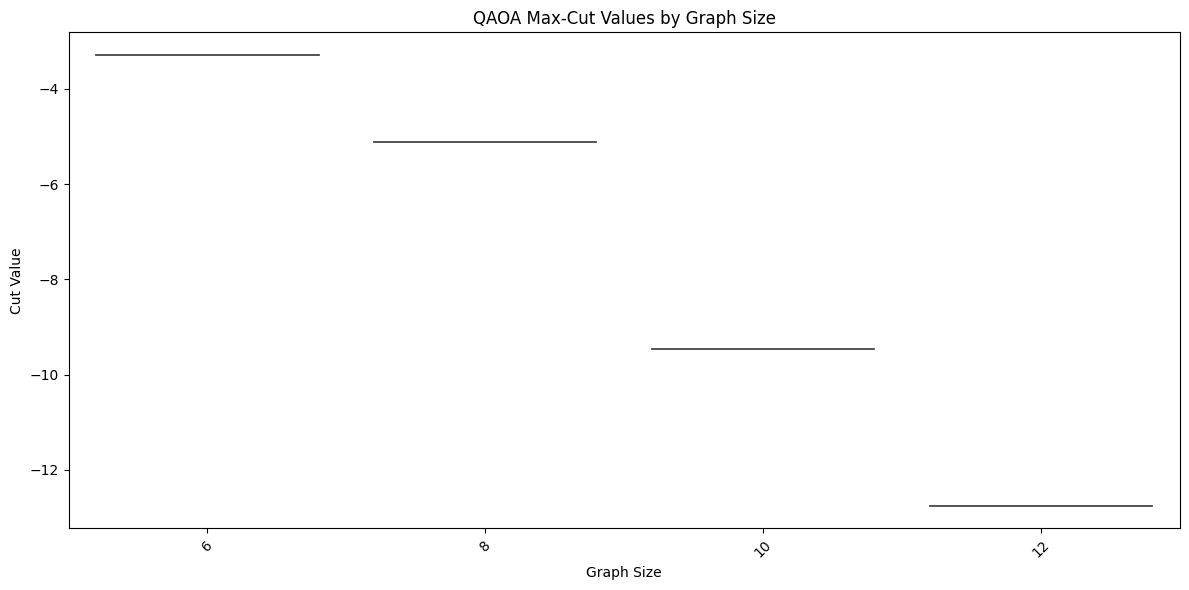

In [11]:
sizes = [6, 8, 10, 12]
edge_prob = 0.5
time_per_size = 45
num_rounds = 50

cut_values = run_qaoa_experiment_time_budget(sizes, edge_prob, time_per_size, num_rounds)

df = pd.DataFrame({
    'Graph Size': np.repeat(sizes, [len(cut) for cut in cut_values]),
    'Cut Value': np.concatenate(cut_values)
})

# Save csv
os.makedirs('data/qaoa-data', exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
csv_path = f'data/qaoa-data/qaoa_{timestamp}.csv'
df.to_csv(csv_path, index=False)
print(f"Results saved to {csv_path}")

# Save plot
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
plot_path = f'plots/qaoa-plots/qaoa_violin_{timestamp}.png'

plt.figure(figsize=(12, 6))
sns.violinplot(x='Graph Size', y='Cut Value', data=df, inner='quartile')
plt.title('QAOA Max-Cut Values by Graph Size')
plt.xlabel('Graph Size')
plt.ylabel('Cut Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(plot_path)
print(f"Plot saved to {plot_path}")
plt.show()